<a href="https://colab.research.google.com/github/xc308/Diffusion_Sampling/blob/main/Denoising_Diffusion_2_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r requirements.txt

##Some Utility functions

In [ ]:
import jax
import numpy as np
from itertools import repeat


In [ ]:
# (vectorized map) transformation to perform batched element-wise multiplication of two inputs, a and b.

def batch_mul(a, b):
    return jax.vmap(lambda a, b: a * b)(a, b)


def batch_div(a, b):
    return jax.vmap(lambda a, b: a / b)(a, b)


def numpy_collate(batch):
    """Collate function for numpy arrays (see https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)."""
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(np.array(samples)) for samples in transposed]




# feed in data continuously
# data_loader yields batch data A, B, C in one epoch,
# repeater yields data batch infinitely A, B, C, A, B, C, ....
def repeater(data_loader):
    for loader in repeat(data_loader): #repeat(x) produces an iterator that yields x endlessly
        for data in loader:
            yield data # yields a generator that gives batch data on demand




## Creating datasets
- The goal is to interpolate between the so-called circle distribution and a std. Gaussian distribution

- To create the data, use sklearn

- To create the datasets we use torch.utils.data.Dataset

- The target dataset (double circle) is stored in target_ds and the reference dataset (standard Gaussian) is stored in reference_ds.-

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [ ]:
def load_twodim(num_samples: int,
                dataset: str,
                dimension=2) -> np.ndarray:
    """Create dataset array with num_samples, each sample has dimension 2

    Args:
        num_samples (int): number of samples.
        dataset (str): identifier of the dataset.

    Returns:
        sample (np.ndarray): (num_samples, 2) array of samples.
    """

    if dataset == 'gaussian_centered':
        sample = np.random.randn(num_samples, dimension)
        sample = sample

    if dataset == 'gaussian_shift':
        sample = np.random.randn(num_samples, 2)
        sample = sample + 1.5

    if dataset == 'circle':
      # create two concentric circles
      # X: contain num_samples rows, each row is a coordinate for circle
      # y: denote 0 for internal, 1 for external circle
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=.5)
        sample = X * 4 # scale the coordinates by 4, bigger circle

    if dataset == 'scurve':
      # generates a dataset of points that lie on an 'S'-shaped manifold in 3D space.
      # X: contains 3D coords of the generated samples, each sample is three columns (x, y, z coordinates)
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor

    return sample

In [ ]:
class TwoDimDataClass(Dataset): # a subclass of Pytorch's Dataset base class
                                # can implement __len__ and __getitem__
                                # can be plugged into a DataLoader
                                # used for batching, feed for training, provide items by index
    """Create the two dimensional dataset.

    Args:
        dataset_type (str): identifier of the dataset.
        N (int): number of samples.
        batch_size (int): batch size.
    """

    def __init__(self,  # and instance of the TwoDimDataClass
                 dataset_type: str,   # pars for a particular instance
                 N: int,
                 batch_size: int,
                 dimension = 2
                 ):

        self.X = load_twodim(N, dataset_type, dimension=dimension) # stores data with shape (N, 2) in memory, an attribute of this particular instance
        self.name = dataset_type      # store name
        self.batch_size = batch_size  # store batch_size for below
        self.dimension = dimension    # store dimension

    def __len__(self):                # tell DataLoader how many samples, where an epoch ends,
        return self.X.shape[0]

    def __getitem__(self, idx):       # idx can be an int or a range(0, 5), then sample multiple rows
        return self.X[idx]            # DataLoader can fetch data samples, then use collate_fn to stack them

    def get_dataloader(self, shuffle=True): #wrap this dataset object in a DataLoader so training can iterate over mini-batches.
        return DataLoader(
            self,     # a TwoDimDataClass instance, i.e. the dataset,
                      # telling the DataLoader: “this is the thing you should load data from
                      # the DataLoader will use len and getitem to know lenth of sample and fetch sample i
            batch_size=self.batch_size,     # sets how many samples go into each mini-batch
            shuffle=shuffle,
            collate_fn=numpy_collate,
            pin_memory=True, # speed up data transfer from host memory to GPU memory
        )


In [ ]:
target_ds = TwoDimDataClass(dataset_type='scurve',
                              N=1000000,
                              batch_size=256)

reference_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                              N=1000000,
                              batch_size=256)


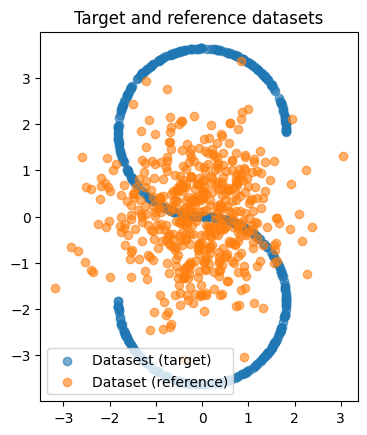

In [ ]:
Ntest = 500
sample_f = target_ds[0:Ntest]
sample_b = reference_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and reference datasets"
ax.set_title(strtitle);
ax.legend(['Datasest (target)', 'Dataset (reference)'])

##Create an abstract SDE class


- defining methods for concrete subclasses

In [ ]:
import abc
from typing import Any
import jax.numpy as jnp
import jax


# Define an abstract class of SDE defining methods that can be impletemented by concrete subclass
class SDE(abc.ABC):   # inherits from abc.ABC
    """SDE is abstract base class. Functions are designed for a mini-batch of inputs.

    Args:
      beta_schedule (Any): Schedule used for the SDE.
      N (int): Number of discretization time steps.
    """

    def __init__(self,
                 N: int):
        super().__init__()    #Calls the parent class (abc.ABC) initializer.
        self.N = N            #Number of discretization time steps. Large, fine steps, more accurate sampling, slower runtime

    @property                 # subclass sde can access as sde.T, not sde.T()
    @abc.abstractmethod       # An abstract method is a method you must implement in any subclass, so any concrete subclass sde must must provide these pieces
    def T(self):
        """End time of the SDE."""
        pass

    @abc.abstractmethod
    def sde_coeff(self, t, x):
        pass

    @abc.abstractmethod
    def marginal_prob(self, t, x):
        """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, rng, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass


    def reverse(self,
                model: Any,
                params: Any) -> Any:
        """Create the reverse-time SDE/ODE.

        Args:
          model (Any): the network used (see config/network).
          params (Any): the parameters of the networks.

        Returns:
          sde_backward (Any): the backward SDE.
        """

        # basics of forward SDE
        N = self.N
        T = self.T
        sde_coeff = self.sde_coeff


        def get_model_fn(model, params):
            key = jax.random.PRNGKey(0)     # NN model is deterministic, no dropout and random layer
            def model_fn(t, x):
                return model.apply(params, key, t, x)   # the score estimated by NN
            return model_fn
        # NOTE: model_fn parameterizes the score.

        def get_reverse_drift_fn(model_fn):
            def reverse_drift_fn(t, x):
                # TO FILL
                drift, diffusion = sde_coeff(self.T-t, x)   # Reverse sde runs t, forward sde then run T - t
                score = model_fn(self.T-t, x)
                reverse_drift = - drift + batch_mul(diffusion ** 2, score)
                return reverse_drift
            return reverse_drift_fn

        # Build the class for reverse-time SDE.

        class RSDE(self.__class__): #defines a new class inside the method,
                                    #inherits class from concrete subclass of an sde instance
                                    #only override what changes for the reverse process
            def __init__(self):
                self.N = N
                self.param_drift = 'score'  #metadata flag, “this drift uses a score model”
                self.model_fn = get_model_fn(model, params)
                self.reverse_drift_fn = get_reverse_drift_fn(self.model_fn)

            @property
            def T(self):
                return T

            def sde_coeff(self, t, x):
                """Create the drift and diffusion functions for the reverse SDE/ODE."""
                _, diffusion = sde_coeff(self.T-t, x) # forward sde use reparametrized T-t
                drift = self.reverse_drift_fn(t, x)   # reverse sde use t
                return drift, diffusion

        sde_backward = RSDE()
        return sde_backward


## Creating the Ornstein-Uhlenbeck process

- OU-SDE is dXt = -0.5 Xt dt + dWt

      drift coef = -0.5Xt

      diffusion coef = 1

- the solution to this SDE is Xt = exp(-0.5t) + sqrt(1 - exp(-t)) z, z ~ N(0, I)

- So, marginal Xt ~ N(exp(-0.5t)*X0, 1 - exp(-t))

In [ ]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self,
                 N=100):   # discritization 100 steps
        """Construct an Ornstein-Uhlenbeck SDE."""

        super().__init__(N)
        self.N = N

    @property
    def T(self):
        return 1

    def sde_coeff(self, t, x):
        # The drift and the matrix diffusion coefficients of foward OU SDE
        drift = -0.5 * x
        diffusion = jnp.ones(x.shape)
        return drift, diffusion

    def marginal_prob(self, t, x):
        # mean, std. of noisy sample X_t.
        exponent = -0.5 * t
        mean = batch_mul(jnp.exp(exponent), x)
        std = batch_mul(jnp.sqrt(1 - jnp.exp(2. * exponent)), x*0+1)
        return mean, std

    def prior_sampling(self, key, shape):
        # Sample from the prior distribution N(0, I)
        return jax.random.normal(key, shape)


# instantiate the class OrnsteinUhlenbeck, create an object of it sde, then can access its property and methods
sde = OrnsteinUhlenbeck()

## Visualisation of the foward jump process

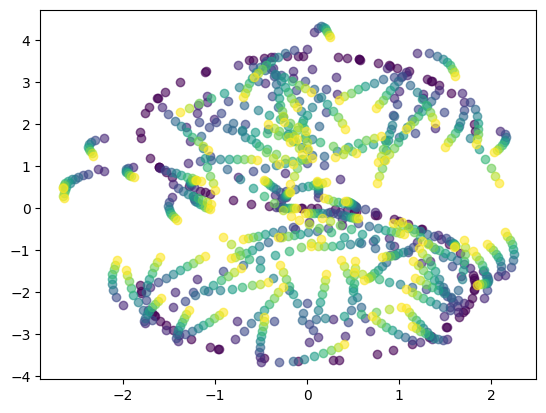

In [ ]:
cmap = plt.get_cmap('viridis')

n_arr = 10
plot_Ntest = 100

t_arr = jnp.linspace(0, sde.T, n_arr)
mean_arr = jnp.zeros((n_arr, 1))
std_arr = jnp.zeros((n_arr, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, tt in enumerate(t_arr):
    x0 = target_ds.__getitem__(range(plot_Ntest))
    t = jnp.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    key = jax.random.PRNGKey(0)
    z = jax.random.normal(key, mean.shape)
    xt = mean + batch_mul(std, z)

    mean_arr = mean_arr.at[k].set(jnp.sum(xt.mean(axis=0)**2))
    std_arr = std_arr.at[k].set(
        jnp.sum((xt.std(axis=0) - 1)**2))

    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.6, color=cmap(tt))

## Define NN

- get embedding for the time input using positional encoding to capture the temporal dependence between adjacent time steps t, and t+delta_t
- leading to more accurate score or noise predictions and better generative performance
- concatenate these embeddings and apply another layer of MLP

In [ ]:
from typing import Any
import math
from dataclasses import dataclass
import haiku as hk
import jax.nn as jnn
import jax.numpy as jnp


#Get timesteps embedding.
 #   Function extracted from https: // github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
def get_timestep_embedding(timesteps: jnp.ndarray,
                           embedding_dim: int,
                           max_positions=10000) -> jnp.ndarray:
    """
    Args:
        timesteps (jnp.ndarray): timesteps array (Nbatch,).
        embedding_dim (int): Size of the embedding.
        max_positions (int, optional): _description_. Defaults to 10000.

    Returns:
        emb (jnp.ndarray): embedded timesteps (Nbatch, embedding_dim).
    """
    assert len(timesteps.shape) == 1
    half_dim = embedding_dim // 2
    # magic number 10000 is from transformers
    emb = math.log(max_positions) / (half_dim - 1)
    # emb = math.log(2.) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
    # emb = tf.range(num_embeddings, dtype=jnp.float32)[:, None] * emb[None, :]
    # emb = tf.cast(timesteps, dtype=jnp.float32)[:, None] * emb[None, :]
    emb = timesteps[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = jnp.pad(emb, [[0, 0], [0, 1]])
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [ ]:
@dataclass # don't have to write an __init__ method manually to store hidden_shapes, output_shape, and bias as instance variables.
           #The dataclass decorator handles these
class MLP:
    hidden_shapes: list    # define the number of neurons in each hidden layer of the MLP.
    output_shape: list     # defines the number of neurons in the final output layer of the MLP
    bias: bool = True      # declares an instance attribute bias, layers include bias

    def __call__(self, x): #This method defines the forward pass of the neural network
        for hs in self.hidden_shapes:
            x = hk.Linear(output_size=hs, with_bias=self.bias)(x) #defines a linear transformation (a fully connected layer), The output of this linear layer becomes the new x for the next step.
            x = jnp.sin(x) # (sine) activation function is applied element-wise to the output x

        x = hk.Linear(output_size=self.output_shape)(x) #After all hidden layers have been processed, this line adds the final output layer
                                                        #The output from the last hidden layer (x) is passed through this final linear layer.
                                                        #This output will typically be the score function prediction or noise prediction.



        return x


In [ ]:
class Naive(hk.Module): #  inherits from hk.Module, standard practice in Haiku for defining neural network components
    """Create a naive MLP network.

    Args:
        output_shape (int): output shape. The desired dimension of the final output from the network
        enc_shapes (int): The shapes of the encoder. The list of hidden layer sizes for the 'encoder' MLPs (for t_encoder and x_encoder).
        t_dim (int): the dimension for generating the time embedding.
        dec_shapes (int): The shapes of the decoder. The list of hidden layer sizes for the main 'decoder' MLP (self.net).
        resnet (bool): if True then the network is a resnet.
    """

    def __init__(
        self,
        output_shape: int,
        enc_shapes: int,
        t_dim: int,
        dec_shapes: int,
    ):
        super().__init__() # inherit from hk.Module, handles parameter
        self.temb_dim = t_dim
        t_enc_dim = t_dim * 2 #the output dimension for the time encoder MLP.

        self.net = MLP(hidden_shapes=dec_shapes,
                       output_shape=output_shape) #main network that takes the combined encoded features of x and t and produces the final output (the score or noise prediction)

        self.t_encoder = MLP(
            hidden_shapes=enc_shapes,
            output_shape=t_enc_dim
        ) #further process the time embedding

        self.x_encoder = MLP(
            hidden_shapes=enc_shapes,
            output_shape=t_enc_dim
        ) #encode the input data x into a feature representation that can be combined with the encoded time embedding.

    def __call__(self, t, x): #defines the forward pass of the neural network.
                              # executed when an instance of Naive is called.
                              # takes current time t and data x as inputs
        t = jnp.array(t, dtype=float)
        if len(x.shape) == 1:
            #x = x.unsqueeze(0) it adds a new dimension at the beginning, (batchsize = 1, num_columns)
            x = jnp.expand_dims(x, 0)

        temb = get_timestep_embedding(t.reshape(-1), self.temb_dim) #transform the raw time t into a higher-dimensional time embedding.
                                                                    #t.reshape(-1) flatten the array into a 1-D vector
        temb = self.t_encoder(temb) # Passes the initial time embedding (temb) through the self.t_encoder MLP. further processes and transforms the time features into a richer representation.
        xemb = self.x_encoder(x)   # Passes the input data x through the self.x_encoder MLP. transforms the raw data into a feature representation that captures its essential characteristics relevant to the network's task.
        temb = jnp.broadcast_to(temb, [xemb.shape[0], *temb.shape[1:]]) #xemb.shape[0] is the batchsize, *temb.shape[1:]] is encoded_time_dimension without batchsize
        h = jnp.concatenate([xemb, temb], -1) #input for the final prediction MLP.
        out = -self.net(h) #Passes the combined feature vector h through the main self.net MLP to produce the final output.

        return out

In [ ]:
def init_model(key, batch_size=64, dimension=2):
    """ Initialize a model. """
    def forward(t, x):
        model = Naive(output_shape=dimension,
                    enc_shapes=[32, 32],
                    t_dim=16,
                    dec_shapes=[32,32])
        return model(t, x)
    model = hk.transform(forward) # contains 2 functions: model.init to initialize NN pars
                                  # model.apply to perform the foward pass of NN, with input key, pars, input data, and return output of the NN

    input_shape = (batch_size, dimension)
    t_shape = (batch_size, 1)
    dummy_t = jnp.zeros(t_shape)
    dummy_input = jnp.zeros(input_shape)

    init_params = model.init(key, t=dummy_t, x=dummy_input) # initialize the pars shape for NN,
                                                            # a nested dict-like PyTree, keyed by module names and parameter names
                                                            # includes everything for t_encoder, x_encoder, net and and their internal linear layers
    return model, init_params #initial weights for training

key = jax.random.PRNGKey(0)
model, init_params = init_model(key, batch_size=target_ds.batch_size, dimension=2)

## Define Training Loss

In [ ]:
import optax

class DSMLoss():
    """Compute the Denoising Score Matching loss.

    Args:
        alpha (float): regularization parameter.
        sde (Any): SDE object.
        diff_weight (bool): whether to weight the loss by the diffusion.
    """

    def __init__(self,
                 alpha: float,
                 diff_weight: bool):
        self.alpha = alpha
        self.diff_weight = diff_weight

    def loss_fn(self, params, key, model, batch):
        t, xt, pred, diffusion_sq = batch
        out = model.apply(params, key, t, xt).squeeze()
        l2loss = optax.l2_loss(out, pred.squeeze())
        reg = out ** 2
        loss = l2loss + self.alpha * reg
        if self.diff_weight:
            loss = loss / diffusion_sq.squeeze()
        loss = jnp.mean(loss)
        return loss

loss_fn = DSMLoss(alpha=0, diff_weight=False).loss_fn
optimizer = optax.adam(learning_rate=1e-3, b1=.9, b2=0.999, eps=1e-8) # b1: decay for the first moment (the mean of gradients), i.e., “momentum”
                                                                      # b2: decay for the second moment (the mean of squared gradients), i.e., “RMS / variance estimate”



## Define an updating step funtion step_fn for one training iteration

- t: a uniformly random sampled from epsilon and 1, epsilon is very small

- xt: the X value at time t given one element in a batch (corresponds to x0)

- pred: the score or noise to be predicted by NN. Grad log q(xt|x0) = - z/std

- diffusion_sq: the square of the diffusion coefficients

In [ ]:
def get_step_fn(loss_fn: Any,
                optimizer: Any,
                sde: Any,
                model: Any) -> Any:
    """Create one step of optimization.

    Args:
        loss_fn (Any): The loss function (see config/loss).
        optimizer (Any): The optimizer (see config/optim).
        model (Any): The neural network (see config/network).

    Returns:
        step_fn (Any): The learning state function.
    """

    def step_fn(key: jax.random.PRNGKey,
                state: Any,
                batch: Any) -> Any:
        """Apply one step of optimization

        Args:
            key (jax.random.KeyArray): random key
            state (Any): training state
            batch (Any): batch of data

        Returns:
            state (Any): updated training state.
        """
        key, step_key = jax.random.split(key)


        batch_shape = batch.shape[0]
        t = jax.random.uniform(key, minval=1e-3, maxval=sde.T, shape=(batch_shape,1))
        mean, std = sde.marginal_prob(t, batch)
        _, diffusion = sde.sde_coeff(t, batch)
        diffusion_sq = diffusion ** 2
        z = jax.random.normal(step_key, shape=mean.shape)
        #z = np.random.normal(size=mean.shape)
        xt = mean + batch_mul(std, z)
        pred = - z / std
        batch_tot = (t, xt, pred, diffusion_sq)

        params = state.params
        loss, grad = jax.value_and_grad(loss_fn)(
            params, step_key, model, batch_tot)
        update, new_opt_state = optimizer.update(grad, state.opt_state)
        new_params = optax.apply_updates(params, update)


        # exponential moving average (ema)
        new_params_ema = jax.tree.map(
            lambda p_ema, p: p_ema * state.ema_rate
            + p * (1.0 - state.ema_rate),
            state.params_ema,
            new_params,
        )
        step = state.step + 1
        new_state = state.replace(step=step,
                                  opt_state=new_opt_state, #optimizer internal state, e.g., Adam moments
                                  params=new_params, # updated NN model paras
                                  params_ema=new_params_ema) # updated ema

        return new_state, loss, key
    return step_fn


step_fn = get_step_fn(loss_fn, optimizer, sde, model)

##Training Model
First create Flax data class to keep track infomation related to forward diffusion and state for training seperately


In [ ]:
import flax

@flax.struct.dataclass
class DiffusionState:
    dataclass: Any
    step_fn: Any

diffusion = DiffusionState(dataclass=target_ds, step_fn=step_fn)
# can use this diffusion directly in the following training code,
# and do not need to pass in target_ds, and step_fn seperately


@flax.struct.dataclass
class State:
    step: int
    opt_state: Any
    params: Any
    ema_rate: float
    params_ema: Any


## initialize the state params
step = 0
opt_state = optimizer.init(init_params)
params = init_params
params_ema = init_params


state = State(step=step,
              opt_state=opt_state,
              params=params,
              ema_rate=0.99,
              params_ema=params_ema)


In [ ]:
from tqdm import tqdm

def train_diffusion(diffusion, state, steps_total):

    dataclass = diffusion.dataclass
    step_fn = jax.jit(diffusion.step_fn)    # compile all the steps in step_fun in one big computation, fast

    trange = tqdm(
        range(0, steps_total),
        bar_format="{desc}{bar}{r_bar}",
        mininterval=1,
        )
    dataloader = dataclass.get_dataloader() # output batch iterable, defined in the dataclass
    diff_iter = iter(repeater(dataloader))  # iterator generator for batches never ends

    key = jax.random.PRNGKey(0)

    for step in trange:
        batch = next(diff_iter)    # iterate the next batch
        state, loss, key = step_fn(key, state, batch)
        if step % 500 == 0:
            trange.set_description(
                "Loss: {:.3f}".format(loss))
    return state



In [ ]:
steps_total = 10000 #training iterations (number of times parameter updates)
state = train_diffusion(diffusion, state, steps_total)

          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loss: 2.131: ██████████| 10000/10000 [00:46<00:00, 215.88it/s]


##Sampling from the backward process

In [ ]:
class Predictor(abc.ABC):
    """The abstract class for a predictor algorithm."""

    def __init__(self, sde):
        super().__init__()
        self.sde = sde

    @abc.abstractmethod
    def update_fn(self,
                  key: jax.random.PRNGKey,
                  t: jnp.ndarray,
                  x: jnp.ndarray) -> Any:
        """One update of the predictor.

        Args:
          key (jax.random.PRNGKey): A JAX random state.
          t (jnp.ndarray): A JAX array representing the current time step.
          x (jnp.ndarray): A JAX array representing the current state

        Returns:
          x (jnp.ndarray): A JAX array of the next state.
          x_mean (jnp.ndarray): A JAX array. The next state without random noise. Useful for denoising.
          pred (jnp.ndarray): a JAX array. The prediction used in the loss function.
        """
        pass


class EulerMaruyamaPredictor(Predictor):
    def __init__(self, sde):
        super().__init__(sde)
        self.param_drift = self.sde.param_drift

    def update_fn(self, key, t, x):
        dt = 1. / self.sde.N
        z = jax.random.normal(key, x.shape)
        drift, diffusion = self.sde.sde_coeff(t, x) # reverse sde use t
        x_mean = x + dt * drift
        x = x_mean + batch_mul(diffusion, jnp.sqrt(dt) * z)
        return x, x_mean



class Sampler():
    """Create a sampling class.

    Args:
      eps (float): A float representing the epsilon stopping time for the backward diffusion.
    """

    def __init__(self, eps: float):
        self.eps = eps


    def get_sampling_fn(self,
                        sde: Any,
                        dataset: Any) -> Any:
        """Create a sampling function.

        Args:
          sde (Any): An SDE.
          dataset (Any): The dataset associated with this SDE (initialization).

        Returns:
          sampling_fn (Any): A sampling function which takes as input a random key and a number of samples.
        """

        update_fn = EulerMaruyamaPredictor(sde).update_fn

        def sampling_fn(key: jax.random.PRNGKey, N_samples: int) -> Any:
            """_summary_

            Args:
                key (jax.random.PRNGKey): A JAX random state.
                N_samples (int): The number of samples.

            Returns:
                out (jnp.ndarray): the last sample of the SDE (N_samples, dimension).
                ntot (int): the total number of steps of the sampling procedure.
                timesteps (jnp.ndarray): the timesteps of the sampling procedure.
                x_hist (jnp.ndarray): the total history of the SDE (N, N_samples, dimension) (N is the number of timesteps).
                pred_hist (jnp.ndarray): the total history of the predictions of the SDE (N, N_samples, dimension) (N is the number of timesteps).
            """
            # Initial sample
            x = dataset.__getitem__(range(N_samples))

            timesteps = jnp.linspace(0, sde.T - self.eps, sde.N) # start 0, stop, total num of steps

            def loop_body(i, val):
                key, x, x_mean, x_hist = val     # unpack carry over
                t = timesteps[i]
                vec_t = jnp.ones((x.shape[0], 1)) * t
                key, step_key = jax.random.split(key)
                x, x_mean = update_fn(step_key, vec_t, x)
                x_hist = x_hist.at[i].set(x)
                return key, x, x_mean, x_hist

            # Get shape for predictions update
            t = jnp.ones((x.shape[0], 1))

            x_hist = jnp.zeros((sde.N, *x.shape)) #sde.N is numb of discretization steps
            _, x, _, x_hist = jax.lax.fori_loop(
                0, sde.N, loop_body, (key, x, x, x_hist))  # for i in 0 to sde.N, loop over the body, update its output, take last arg as initial
            out = x     # x at the last timestep
            ntot = sde.N
            return out, ntot, timesteps, x_hist

        return sampling_fn




In [ ]:
sde_backward = sde.reverse(model, state.params_ema)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, reference_ds)

out, ntot, timesteps, x_hist = sampler_fn(key, N_samples=100)

##Visualisation

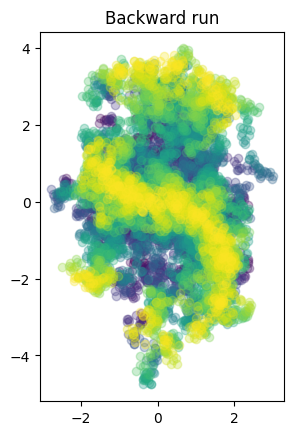

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t_arr = jnp.linspace(0, 1, plot_Ntest)

for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt))

ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Backward run"
ax.set_title(strtitle);

Text(0.5, 1.0, 'Vector field at time t=0.95')

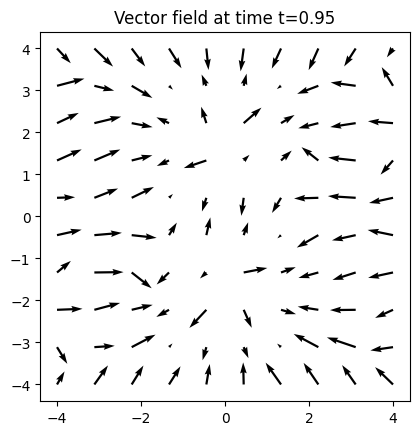

In [ ]:
xmin, xmax = -4, 4 # create square region [-4, 4] by [-4, 4]
ymin, ymax = -4, 4
xx, yy = jnp.mgrid[xmin:xmax:10j, ymin:ymax:10j] # create 10 evenly spaced grids from xmin to xmax, and for y
                                                # 10j indicate 10 points
                                                # xx, yy are x-, y- coordinates
fig = plt.figure()      # starts a new figure canvas.

t0 = 0.05               # want the vector field at time t = 0.05
x = jnp.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1) # Build a list of (x, y) points from the grid
                                                     # flattens the 10×10 grid into a column vector of length 100, shape(100,1)
                                                     # concatenate along the last axis (axis=-1) to pair them up, x has shape (100, 2)
                                                     # x[i] is a 2D point [x_coord, y_coord]

t = jnp.zeros((x.shape[0],)) + t0                    # vector of 100 copies of 0.05, t has shape (100,)
out = model.apply(state.params_ema, key, t, x)       # apply the model, with trained ema_pars, key, input (t, x)
                                                     # For each of these 100 points x[i] at time t[i], give me the output, shape (100, 2)
u = out[:, 0].reshape(xx.shape)                      # Split the model output into u- and v-components and reshape back to a grid
                                                     # reshape into xx.shape which is (10, 10), so now u is (10, 10)
v = out[:, 1].reshape(yy.shape)                      # at each grid cell (i, j), have a vector (u[i, j], v[i, j])

ax = fig.add_subplot(1, 1, 1)                        # makes a single axes in the figure
ax.quiver(xx, yy, u, v)                              # draws arrows, base position (xx, yy), arrow direction (u, v)

ax.set_aspect('equal', adjustable='box')
strtitle = "Vector field at time t=0.95"
ax.set_title(strtitle)

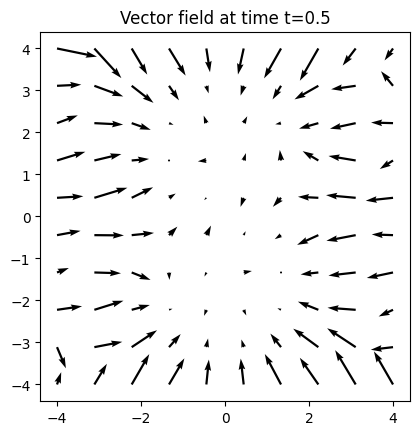

In [ ]:
xmin, xmax = -4, 4 # create square region [-4, 4] by [-4, 4]
ymin, ymax = -4, 4
xx, yy = jnp.mgrid[xmin:xmax:10j, ymin:ymax:10j] # create 10 evenly spaced grids from xmin to xmax, and for y
                                                # 10j indicate 10 points
                                                # xx, yy are x-, y- coordinates
fig = plt.figure()      # starts a new figure canvas.

t0 = 0.5               # want the vector field at time t = 0.05
x = jnp.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1) # Build a list of (x, y) points from the grid
                                                     # flattens the 10×10 grid into a column vector of length 100, shape(100,1)
                                                     # concatenate along the last axis (axis=-1) to pair them up, x has shape (100, 2)
                                                     # x[i] is a 2D point [x_coord, y_coord]

t = jnp.zeros((x.shape[0],)) + t0                    # vector of 100 copies of 0.05, t has shape (100,)
out = model.apply(state.params_ema, key, t, x)       # apply the model, with trained ema_pars, key, input (t, x)
                                                     # For each of these 100 points x[i] at time t[i], give me the output, shape (100, 2)
u = out[:, 0].reshape(xx.shape)                      # Split the model output into u- and v-components and reshape back to a grid
                                                     # reshape into xx.shape which is (10, 10), so now u is (10, 10)
v = out[:, 1].reshape(yy.shape)                      # at each grid cell (i, j), have a vector (u[i, j], v[i, j])

ax = fig.add_subplot(1, 1, 1)                        # makes a single axes in the figure
ax.quiver(xx, yy, u, v)                              # draws arrows, base position (xx, yy), arrow direction (u, v)

ax.set_aspect('equal', adjustable='box')
strtitle = "Vector field at time t=0.5"
ax.set_title(strtitle);

Text(0.5, 1.0, 'Vector field at time t=0.95')

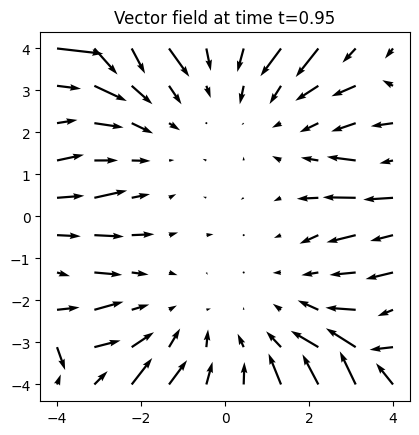

In [ ]:
xmin, xmax = -4, 4 # create square region [-4, 4] by [-4, 4]
ymin, ymax = -4, 4
xx, yy = jnp.mgrid[xmin:xmax:10j, ymin:ymax:10j] # create 10 evenly spaced grids from xmin to xmax, and for y
                                                # 10j indicate 10 points
                                                # xx, yy are x-, y- coordinates
fig = plt.figure()      # starts a new figure canvas.

t0 = 0.95               # want the vector field at time t = 0.05
x = jnp.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1) # Build a list of (x, y) points from the grid
                                                     # flattens the 10×10 grid into a column vector of length 100, shape(100,1)
                                                     # concatenate along the last axis (axis=-1) to pair them up, x has shape (100, 2)
                                                     # x[i] is a 2D point [x_coord, y_coord]

t = jnp.zeros((x.shape[0],)) + t0                    # vector of 100 copies of 0.05, t has shape (100,)
out = model.apply(state.params_ema, key, t, x)       # apply the model, with trained ema_pars, key, input (t, x)
                                                     # For each of these 100 points x[i] at time t[i], give me the output, shape (100, 2)
u = out[:, 0].reshape(xx.shape)                      # Split the model output into u- and v-components and reshape back to a grid
                                                     # reshape into xx.shape which is (10, 10), so now u is (10, 10)
v = out[:, 1].reshape(yy.shape)                      # at each grid cell (i, j), have a vector (u[i, j], v[i, j])

ax = fig.add_subplot(1, 1, 1)                        # makes a single axes in the figure
ax.quiver(xx, yy, u, v)                              # draws arrows, base position (xx, yy), arrow direction (u, v)

ax.set_aspect('equal', adjustable='box')
strtitle = "Vector field at time t=0.95"
ax.set_title(strtitle)

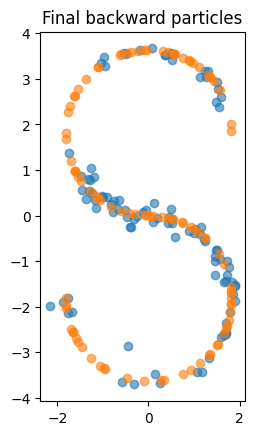

In [ ]:
out_true = target_ds[range(0, plot_Ntest)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)             # creates a single axes panel: 1 row, 1 column, first (only) subplot

ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)   # x.shape is (N_samples, 2), x_hist.shape is (sde.N, N_samples, 2), sde.N steps, each step has N_samples, each sample has 2 dims
                                                            # means: final timestep, all samples, x-coordinate, shape (N_samples, )
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)       # final timestep, all samples, y-coordinate

ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Final backward particles"
ax.set_title(strtitle);

## Onto image datasets

In [ ]:
import torchvision      # datasets + image transforms for PyTorch
from torchvision import transforms  # a toolbox of preprocessing steps you can chain together.
import torch


# define a pipeline that will be applied to each MNIST image when you access it
transforms_list = [
    transforms.Pad(2, fill=0),  # MNIST images are 28×28 grayscale, adding by 2 on all sides adds 2 pixels to top/bottom, filled with 0 black pixels, new size 32 by 32
    transforms.ToTensor(),      # Converts a PIL image (or NumPy image) to a PyTorch tensor
                                # dtype: torch.float32; shape: (C, H, W) = (1, 32, 32) (1 channel grayscale)
                                # values scaled to [0, 1] (MNIST pixels originally 0–255)
    transforms.Lambda(lambda t: (t * 2) - 1) #rescales pixel values from [0, 1] → [-1, 1]
]


# Create the dataset object
mnist_ds = torchvision.datasets.MNIST(root='.',    #store data in the current directory
                                      train=True,  # use the training split (60k images)
                                      download=True, # download
                                      transform=transforms.Compose(transforms_list)) #apply your preprocessing pipeline whenever fetch an item

images = np.array(torch.cat([mnist_ds[i][0] for i in range(1000)])) #Extract the first 1000 transformed images into a NumPy array
          # mnist_ds[i] each image element is a tuple (image_tensor, label)
          # image_tensor: shape (1, 32, 32) with values in [-1, 1]
          # label: integer 0–9

          # torch.cat() stacks those 1000 tensors along the first dimension,
          # output: one tensor of shape (1000, 32, 32)


In [ ]:
# Compute mean and std

mean, std = images.mean(), images.std()
print(f'Mean: {mean:.3f}, Standard Deviation: {std:.3f}')

Mean: -0.804, Standard Deviation: 0.545


In [ ]:
class ImageDataClass(Dataset):
    """Create a flatten image dataset.

    Args:
        dataset_type (str): identifier of the dataset.
        N (int): number of samples.
        batch_size (int): batch size.
    """

    def __init__(self,
                 image_ds: Any,
                 batch_size: int,
                 mean: float = 0.,
                 std: float = 1.):

        self.image_ds = image_ds
        self.batch_size = batch_size
        self.mean = mean
        self.std = std

    def __len__(self):
        return self.image_ds.__len__()

    def __getitem__(self, idx):
        return ((self.image_ds.__getitem__(idx)[0].numpy() - self.mean) / self.std).transpose(1, 2, 0)
        # self.image_ds.__getitem__(idx) get an minst_ds item: a tuple (image tensor, label)
        # self.image_ds.__getitem__(idx)[0] only want the image tensor
        # turn the tensor into a numpy array
        # standardize
        # transpose from CHW (channel, height, width) (1, 32, 32) to HWC (height, width, channel) (32, 32, 1)
        # each sample is shape (32, 32, 1)
        # each batch is sahpe (B, 32, 32, 1)

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            collate_fn=numpy_collate,
            pin_memory=True,
        )

## instantiation
image_ds = ImageDataClass(mnist_ds, batch_size=128, mean=mean, std=std)
    # produce normalized NumPy images in HWC format
    # allow image_ds.get_dataloader() to yield batches

In [ ]:
class TimeEmbedding(hk.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate(
            (jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1
        )
        return embeddings

In [ ]:
#" Conv → Normalization → Activation” building block
# A feature-extraction step that takes an input tensor x and
# produces a transformed tensor with dim_out channels:
    # 3×3 convolution mixes local spatial neighborhoods and changes channel count
    # Group normalization stabilizes training / scales activations nicely
    # SiLU activation adds nonlinearity


class Block(hk.Module):
    def __init__(self, dim_out, groups=8): # dim_out: the number of output channels after the convolution
                                           # If input is (H, W, C_in), output becomes (H, W, dim_out)
        super().__init__()
        self.proj = hk.Conv2D(dim_out, kernel_shape=3, padding=(1, 1)) # A 2D convolution layer, 3×3 kernels, add 1 pixel of padding on height and width; Conv2D by default expects NHWC format
        self.norm = hk.GroupNorm(groups)   # GroupNorm splits channels into groups groups and normalizes within each group
        self.act = jax.nn.silu             # Smooth, non-monotonic; works well in modern nets and diffusion UNets; apply non-linearity to represnt complex data

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x


In [ ]:
# “ResNet-style” block with time conditioning
# inputs:
    # x: a feature map, shape usually (B, H, W, C_in)
    # time_emb: a per-sample embedding vector, shape (B, E)
# output:
    # a feature map of shape (B, H, W, dim_out)
# It computes:

    #transform x through a couple of conv+norm+act blocks

    #inject time embedding into the feature map (conditioning)

    #add the original x back (skip connection), after a 1by1 conv to match dimensions


class ResnetBlock(hk.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim_out, groups=8, change_dim=False):
        super().__init__()
        self.mlp = hk.Sequential([jax.nn.silu, hk.Linear(dim_out)])  #applied to the time embedding, input time_emb shape (B, E), siLu, linear layer, output shape(B, dim_out)
        self.block1 = Block(dim_out, groups=groups)  # con2D - groupnormal - silu, transforms input features into dim_out channels
        self.block2 = Block(dim_out, groups=groups)  # after time conditioning, block2 refines them again
        self.res_conv = (
            hk.Conv2D(dim_out, kernel_shape=1, padding=(0, 0))
            if change_dim    # If change_dim=True, it applies a 1×1 convolution to x to make it have dim_out channels
            else lambda x: x # If change_dim=False, then skip path is just identity: x passes through unchanged
        )

    def __call__(self, x, time_emb):
        h = self.block1(x)            # (B, H, W, dim_out)
        time_emb = self.mlp(time_emb) # maps (B, E) to (B, dim_out)
        # We add new axes to the time embedding to for broadcasting, because h is (B, H, W, dim_out)
        #h = h + time_emb[:, None, :]  # (B, 1, 1, dim_out) + (B, H, W, dim_out)
        h = time_emb[:, jnp.newaxis] + h
        h = self.block2(h)                  # shape (B, H, W, dim_out)
        return h + self.res_conv(x)


In [ ]:
# changing spatial resolution in a CNN/UNet:

def SpatialUpsample(dim): #make the image/feature map smaller (downsample by 2)
    return hk.Conv2DTranspose(dim, kernel_shape=4, stride=2)


def SpatialDownsample(dim): #make it bigger (upsample by 2)
    return hk.Conv2D(dim, kernel_shape=4, stride=2, padding=(1, 1))


In [ ]:
class Unet(hk.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1,),
        channels=1,
        resnet_block_groups=1,
    ):
        super().__init__()

        # determine dimensions
        init_dim = dim // 3 * 2
        self.init_conv = hk.Conv2D(init_dim, kernel_shape=7, padding=(3, 3))

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = hk.Sequential(
            [
                TimeEmbedding(dim),
                hk.Linear(time_dim),
                jax.nn.gelu,
                hk.Linear(time_dim),
            ]
        )

        # layers
        self.downs = []
        dims = list(map(lambda m: dim * m, dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            self.downs.append(
                [
                    ResnetBlock(
                        stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    # We don't apply spatial downsampling to the last stage. This is
                    # because we go from 28x28 -> 14x14 -> 7x7 in the 1st and 2nd
                    # stages and 7 can't be halved without a remainder, which
                    # would cause problems in the upsampling path.
                    SpatialDownsample(
                        stage_dim) if not is_last else lambda x: x,
                ]
            )

        mid_dim = dims[-1] # dims is a list of channel widths per downsampling stage, e.g. [64, 128, 256]
        self.mid_block1 = ResnetBlock(mid_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, groups=resnet_block_groups)

        self.ups = []
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(rev_dims) - 1

            self.ups.append(
                [
                    ResnetBlock(
                        stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    SpatialUpsample(stage_dim) if not is_last else lambda x: x,
                ]
            )

        self.final_block = ResnetBlock(dim, groups=resnet_block_groups)
        self.final_conv = hk.Conv2D(channels, kernel_shape=1, padding=(0, 0))

    def __call__(self, time, x):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []
        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)


        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = jnp.concatenate((x, h.pop()), axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = self.final_block(x, t)
        return self.final_conv(x)

In [ ]:
def init_model(key, batch_size=16, dimension=32):
    """ Initialize a model. """
    def forward(t, x):
        model = Unet(dim=32)
        return model(t, x)
    model = hk.transform(forward)

    input_shape = (batch_size, dimension, dimension, 1)
    t_shape = (batch_size, 1)
    dummy_t = jnp.zeros(t_shape)
    dummy_input = jnp.zeros(input_shape)

    init_params = model.init(key, t=dummy_t, x=dummy_input)
    return model, init_params


In [ ]:
def init_model(key, batch_size=16, dimension=32, channels=1):
    def forward(time, x):
        model = Unet(dim=32, channels=channels)
        return model(time, x)

    model = hk.transform(forward)

    dummy_t = jnp.zeros((batch_size, 1), dtype=jnp.float32)
    dummy_x = jnp.zeros((batch_size, dimension, dimension, channels), dtype=jnp.float32)

    init_params = model.init(key, time=dummy_t, x=dummy_x)
    return model, init_params

    init_params = model.init(key, t=dummy_t, x=dummy_input)
    return model, init_params

In [ ]:
key = jax.random.PRNGKey(0)
sde = OrnsteinUhlenbeck(N=1000)
model, init_params = init_model(key, batch_size=image_ds.batch_size, dimension=32)
loss_fn = DSMLoss(alpha=0, diff_weight=False).loss_fn
optimizer = optax.adam(learning_rate=1e-4, b1=.9, b2=0.999, eps=1e-8)
step_fn = get_step_fn(loss_fn, optimizer, sde, model)


In [ ]:
@flax.struct.dataclass
class DiffusionState:
    dataclass: Any
    step_fn: Any

diffusion = DiffusionState(dataclass=image_ds,
                             step_fn=step_fn)


@flax.struct.dataclass
class State:
    step: int
    opt_state: Any
    params: Any
    ema_rate: float
    params_ema: Any


step = 0
opt_state = optimizer.init(init_params)
params = init_params
params_ema = init_params

state = State(step=step,
              opt_state=opt_state,
              params=params,
              ema_rate=0.99,
              params_ema=params_ema)

In [ ]:
steps_total = 10
state = train_diffusion(diffusion, state, steps_total)

          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loss: 5.755: ██████████| 10/10 [00:28<00:00,  2.83s/it]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

dataloader = image_ds.get_dataloader(shuffle=False) # a mini-batch

original = next(iter(dataloader)).reshape(-1, 1, 32, 32)
# next(iter(dataloader)) is shape (B, 32, 32, 1)
# -1 means “infer this dimension” (Bsize), 1 chanel, H, W
noised = original * np.exp(-1) + np.random.normal(0, 1, original.shape) * np.sqrt(1 - np.exp(-2))

images_original = torch.tensor(original.reshape(-1, 1, 32, 32))
images_noised = torch.tensor(noised.reshape(-1, 1, 32, 32))


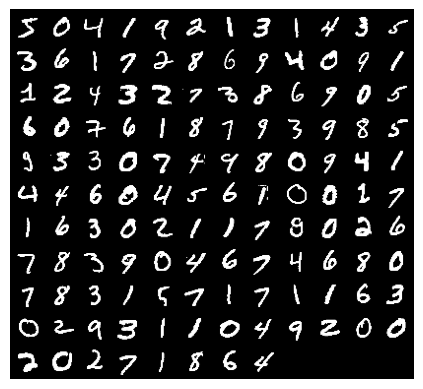

In [ ]:
def show_image_grid(images, nrow=8, padding=2,
                    normalize=False, scale_each=False, pad_value=0):
    """Imshow for Tensor."""
    from torchvision.utils import make_grid
    grid = make_grid(images, nrow=nrow, padding=padding,
                     normalize=normalize, scale_each=scale_each, pad_value=pad_value)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')


show_image_grid(images_original, nrow=12, padding=2)


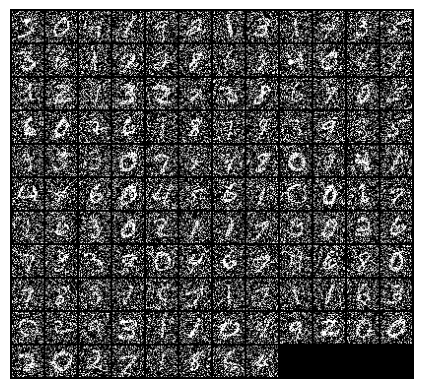

In [ ]:
show_image_grid(images_noised, nrow=12, padding=2)

## Modified sampler for image

In [ ]:
class Predictor(abc.ABC):
    """The abstract class for a predictor algorithm."""

    def __init__(self, sde):
        super().__init__()
        self.sde = sde

    @abc.abstractmethod
    def update_fn(self,
                  key: jax.random.PRNGKey,
                  t: jnp.ndarray,
                  x: jnp.ndarray) -> Any:
        """One update of the predictor.

        Args:
          key (jax.random.PRNGKey): A JAX random state.
          t (jnp.ndarray): A JAX array representing the current time step.
          x (jnp.ndarray): A JAX array representing the current state

        Returns:
          x (jnp.ndarray): A JAX array of the next state.
          x_mean (jnp.ndarray): A JAX array. The next state without random noise. Useful for denoising.
          pred (jnp.ndarray): a JAX array. The prediction used in the loss function.
        """
        pass


class EulerMaruyamaPredictor(Predictor):
    def __init__(self, sde):
        super().__init__(sde)
        self.param_drift = self.sde.param_drift

    def update_fn(self, key, t, x):
        dt = 1. / self.sde.N
        z = jax.random.normal(key, x.shape)
        drift, diffusion = self.sde.sde_coeff(t, x) # reverse sde use t
        x_mean = x + dt * drift
        x = x_mean + batch_mul(diffusion, jnp.sqrt(dt) * z)
        return x, x_mean



class Sampler():
    """Create a sampling class.

    Args:
      eps (float): A float representing the epsilon stopping time for the backward diffusion.
    """

    def __init__(self, eps: float):
        self.eps = eps


    def get_sampling_fn_from_prior(self, sde, sample_shape=(32, 32, 1)):
        """Create a sampling function.

        Args:
          sde (Any): An SDE.
          dataset (Any): The dataset associated with this SDE (initialization).

        Returns:
          sampling_fn (Any): A sampling function which takes as input a random key and a number of samples.
        """

        update_fn = EulerMaruyamaPredictor(sde).update_fn

        def sampling_fn(key: jax.random.PRNGKey, N_samples: int) -> Any:
            """_summary_

            Args:
                key (jax.random.PRNGKey): A JAX random state.
                N_samples (int): The number of samples.

            Returns:
                out (jnp.ndarray): the last sample of the SDE (N_samples, dimension).
                ntot (int): the total number of steps of the sampling procedure.
                timesteps (jnp.ndarray): the timesteps of the sampling procedure.
                x_hist (jnp.ndarray): the total history of the SDE (N, N_samples, dimension) (N is the number of timesteps).
                pred_hist (jnp.ndarray): the total history of the predictions of the SDE (N, N_samples, dimension) (N is the number of timesteps).
            """
            # 1) Start from prior (usually standard Gaussian)
            key, init_key = jax.random.split(key)
            #x = sde.prior_sampling(init_key, (N_samples, *sample_shape))
            # If prior_sampling isn't implemented, use:
            x = jax.random.normal(init_key, (N_samples, *sample_shape))

            timesteps = jnp.linspace(0, sde.T - self.eps, sde.N) # start 0, stop, total num of steps

            def loop_body(i, val):
                key, x, x_mean, x_hist = val     # unpack carry over
                t = timesteps[i]
                vec_t = jnp.ones((x.shape[0], 1)) * t
                key, step_key = jax.random.split(key)
                x, x_mean = update_fn(step_key, vec_t, x)
                x_hist = x_hist.at[i].set(x)
                return key, x, x_mean, x_hist

            # Get shape for predictions update
            t = jnp.ones((x.shape[0], 1))

            x_hist = jnp.zeros((sde.N, *x.shape)) #sde.N is numb of discretization steps
            _, x, _, x_hist = jax.lax.fori_loop(
                0, sde.N, loop_body, (key, x, x, x_hist))  # for i in 0 to sde.N, loop over the body, update its output, take last arg as initial
            out = x     # x at the last timestep
            ntot = sde.N
            return out, ntot, timesteps, x_hist

        return sampling_fn



In [ ]:
key = jax.random.PRNGKey(0)

sde_backward = sde.reverse(model, state.params_ema)
# If reverse returns a tuple in your implementation, use:
# sde_backward, _ = sde.reverse(model, state.params_ema)

sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn_from_prior(sde_backward, sample_shape=(32, 32, 1))

out, ntot, timesteps, x_hist = sampler_fn(key, N_samples=128)

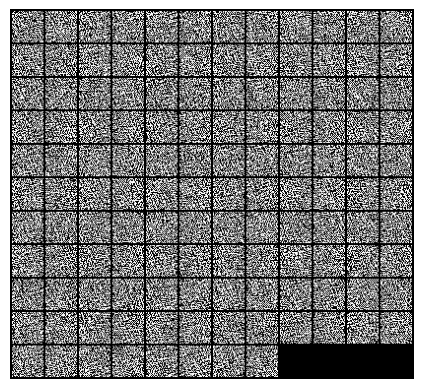

In [ ]:
last = np.array(x_hist[-1])   # (B, 32, 32, 1)
images = torch.from_numpy(last).permute(0, 3, 1, 2).float()  # (B, 1, 32, 32)
images = (images.clamp(-1, 1) + 1) / 2

show_image_grid(images, nrow=12, padding=2)

In [ ]:
for k in [0, 100, 300, 999]:
    last = np.array(x_hist[k])
    images = torch.from_numpy(last).permute(0,3,1,2).float()
    images = (images.clamp(-1,1)+1)/2
    show_image_grid(images[:64], nrow=8)